# LSTM for Stock Prediction

https://medium.com/@aniruddha.choudhury94/stock-market-prediction-by-recurrent-neural-network-on-lstm-model-56de700bff68

In [20]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from IPython.display import display
pd.options.display.max_columns = 50
pd.options.display.html.table_schema = True

In [45]:
UOM = {'K': 1000, 'M': 1000000}

def convert_to_numeric(val):
    return float(val[:-1]) * UOM[val[-1]]

def clean_dataset(df):
    df.rename(columns={'Price':'Close', 'Vol.':'Volume'}, inplace=True)
    df.drop(columns=['Change %'], axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Volume'] = df['Volume'].apply(convert_to_numeric)
    df.sort_values(by=['Date'], ascending=True, inplace=True)
    df.set_index('Date', inplace=True)

dataset = pd.read_csv('data/GENTING_train_set.csv', parse_dates=True)
clean_dataset(dataset)
dataset.head(10)

,Close,Open,High,Low,Volume
Date,,,,,
2011-08-15,10.14,10.10,10.16,10.08,6490000.0
2011-08-16,10.10,10.18,10.24,10.02,3160000.0
2011-08-17,10.04,10.10,10.10,10.02,5410000.0
2011-08-18,9.98,10.14,10.14,9.97,5350000.0
2011-08-19,9.70,9.85,9.85,9.65,11570000.0
2011-08-22,9.51,9.68,9.69,9.49,8520000.0
2011-08-23,9.70,9.55,9.70,9.40,6520000.0
2011-08-24,9.52,9.80,9.80,9.52,5090000.0
2011-08-25,9.78,9.55,9.78,9.54,6120000.0


# Preprocessing

In [48]:
dataset.isna().any()

Close     False
Open      False
High      False
Low       False
Volume    False
dtype: bool

In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1768 entries, 2011-08-15 to 2018-10-31
Data columns (total 5 columns):
Close     1768 non-null float64
Open      1768 non-null float64
High      1768 non-null float64
Low       1768 non-null float64
Volume    1768 non-null float64
dtypes: float64(5)
memory usage: 82.9 KB


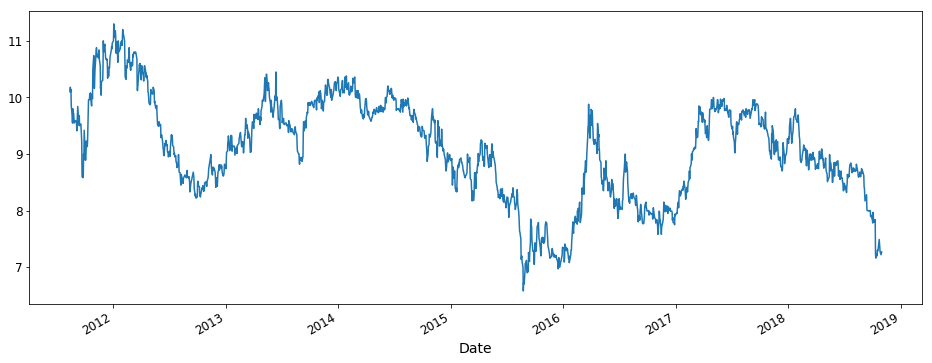

In [50]:
dataset['Open'].plot(figsize=(16,6))

In [52]:
# convert column "a" of a DataFrame
# dataset["Close"] = dataset["Close"].str.replace(',', '').astype(float)

In [53]:
# 7 day rolling mean
dataset.rolling(7).mean().head(20)

,Close,Open,High,Low,Volume
Date,,,,,
2011-08-15,NaN,NaN,NaN,NaN,NaN
2011-08-16,NaN,NaN,NaN,NaN,NaN
2011-08-17,NaN,NaN,NaN,NaN,NaN
2011-08-18,NaN,NaN,NaN,NaN,NaN
2011-08-19,NaN,NaN,NaN,NaN,NaN
2011-08-22,NaN,NaN,NaN,NaN,NaN
2011-08-23,9.881429,9.942857,9.982857,9.804286,6.717143e+06
2011-08-24,9.792857,9.900000,9.931429,9.724286,6.517143e+06
2011-08-25,9.747143,9.810000,9.865714,9.655714,6.940000e+06
